In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
from scipy.linalg import hadamard
import scipy.signal
import pylab

# Set up helper functions

In [2]:
def set_walsh_sim(N, n, stepperiod, verify=False):
        """
        N: order of walsh matrix
        n: walsh index to give this stream
        stepperiod: period (2^?), in multiples of self.periodbase FPGA clocks,
                of shortest walsh step. I.e., 2**13 * 2**self.baseperiod * N
                = period of complete cycle in FPGA clocks.
        """
        depth = 2**12
        N_round = int(2**(np.ceil(np.log2(N))))
        walsh_matrix = hadamard(N_round)
        # reformat so 1 means multiply by -1, and 0 means multiply by 1
        walsh_matrix[walsh_matrix == 1]  = 1
        walsh_matrix[walsh_matrix == -1] = -1
        walsh_func = walsh_matrix[n] # a vector of length N_round
        walsh_func_stretch = walsh_func.repeat(2**stepperiod) # a vector of length N_round * 2*step_period
        return walsh_func_stretch

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

# Generate Walsh Patterns 

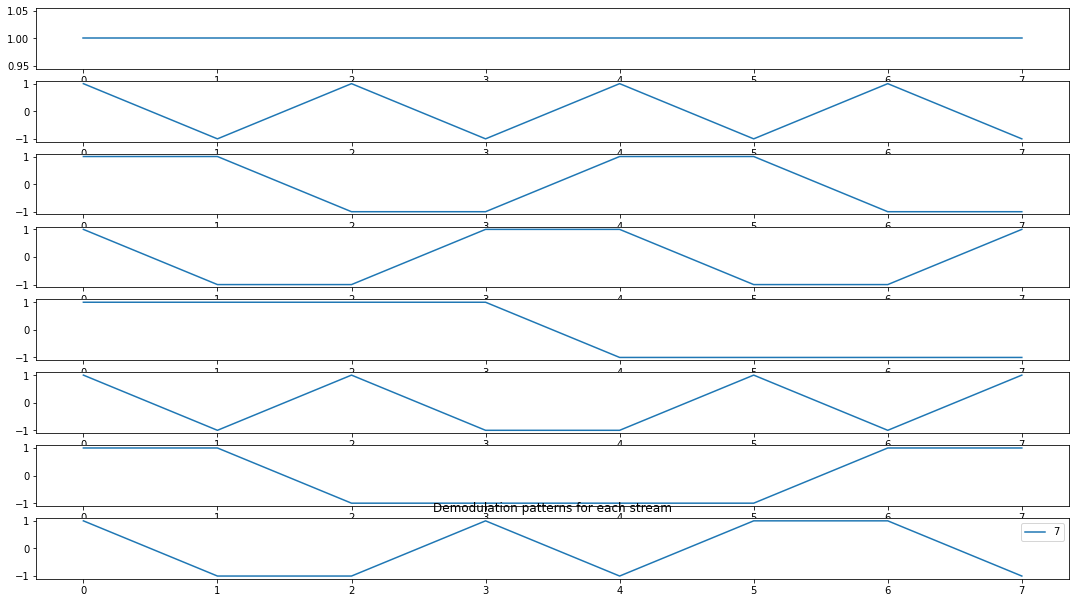

In [3]:
#Generate walsh patterns of a length 8, which could be used for 8 seperate time streams
fig,ax = plt.subplots(8,1)
fig.set_size_inches(18.5, 10.5)
for i in range(8):
    ax[i].plot(set_walsh_sim(8,i,0), label=i)
plt.title('Demodulation patterns for each stream')
plt.legend()
plt.show()

# Can we recover a signal?

In [4]:
# Generate a test data steam that is the appropriate length 
samples = np.arange(1024)
#The "noise" 

noise   = np.random.normal(loc=0, scale=0.1, size=1024) 
freq = 1
freq2 = .5
amp  = 0.2

#The CW signal is our science signal
cw_signal = amp * np.sin(samples * freq2)

#The CW signal is our interferer
cw_signal2 = amp * np.sin(samples * freq)

data = noise + cw_signal 

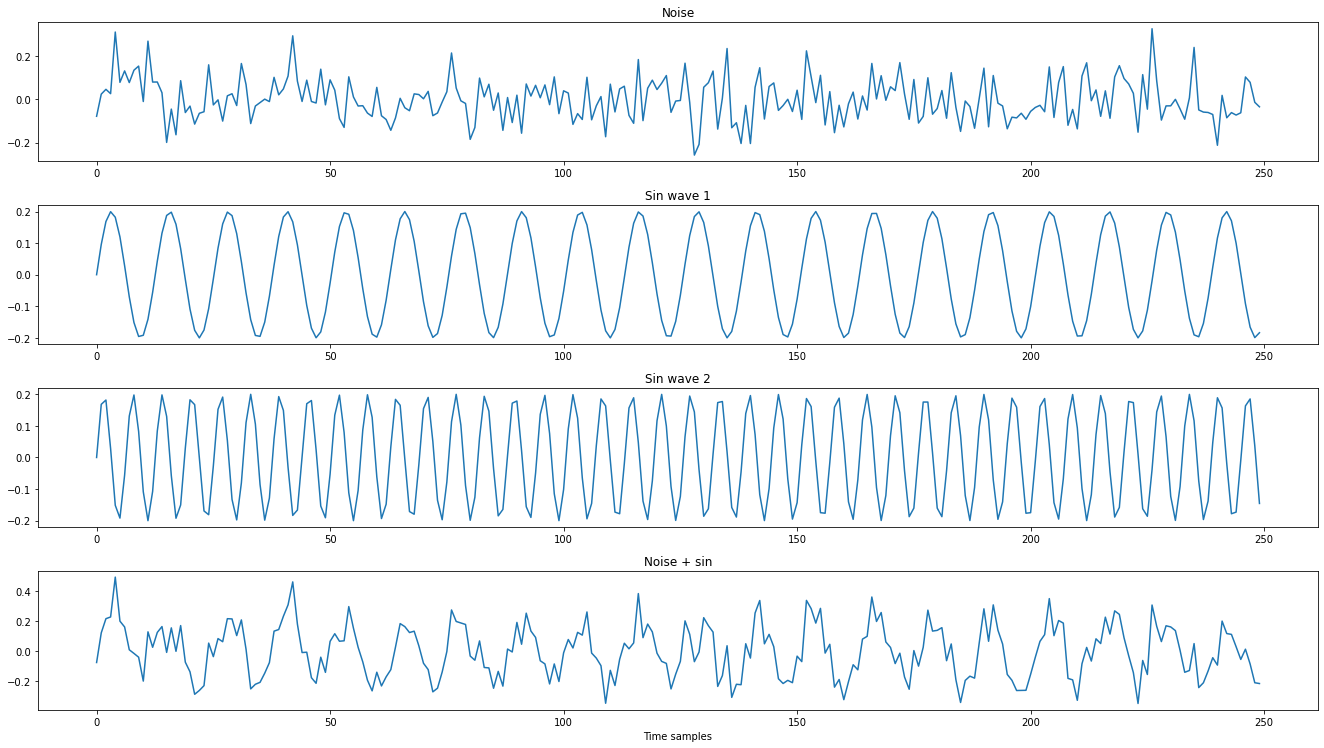

In [5]:
fig,ax = plt.subplots(4,1)
fig.set_size_inches(18.5, 10.5)

plt.subplot(4,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(4,1,2)
plt.title("Sin wave 1")
plt.plot(cw_signal[:250])
plt.subplot(4,1,3)
plt.title("Sin wave 2")
plt.plot(cw_signal2[:250])
plt.subplot(4,1,4)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


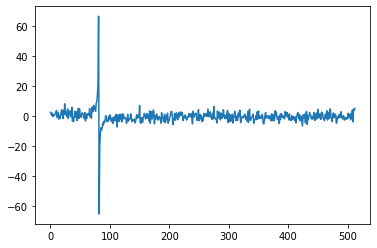

In [6]:
plt.plot(np.fft.rfft(data))

# Modulate test data stream 

In [7]:
#extend the number of samples for the walsh function to match the signal length 
period_base = len(samples)//8
n= 0
n2 = period_base
walsh0 = set_walsh_sim(8,1,0)
walsh0extended = np.zeros(len(samples))
for i in range(len(walsh0)):
    extended = np.array(walsh0[i].repeat(period_base))
    walsh0extended[n:n2] = extended
    n += period_base
    n2 += period_base

In [8]:
n = 0
n2 = period_base
walsh1 = set_walsh_sim(8,2,0)
walsh1extended = np.zeros(len(samples))
for i in range(len(walsh1)):
    extended = np.array(walsh1[i].repeat(period_base))
    walsh1extended[n:n2] = extended
    n += period_base
    n2 += period_base

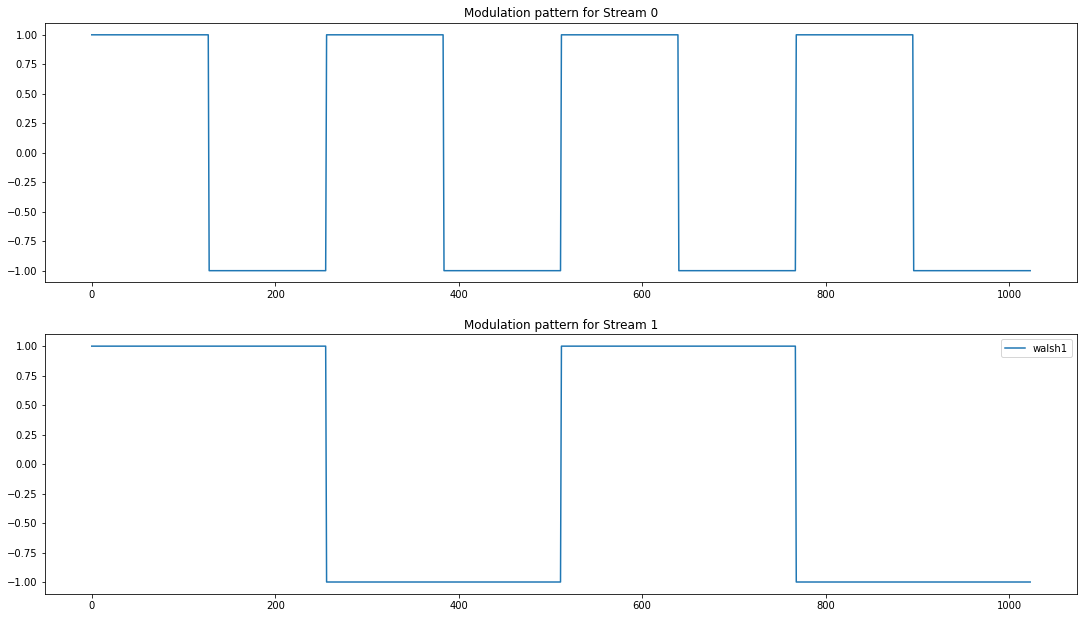

In [9]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Modulation pattern for Stream 0')
ax[1].set_title('Modulation pattern for Stream 1')
ax[0].plot(walsh0extended, label='walsh0')
ax[1].plot(walsh1extended, label='walsh1')
#ax[i].set_xlim(0,10)
plt.legend()
plt.show()

In [10]:
modulated0 = np.zeros(len(walsh0extended))
modulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        modulated0[i] = data[i]
    if walsh0extended[i] == -1:
        modulated0[i] = -data[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        modulated1[i] = data[i]
    if walsh1extended[i] == -1:
        modulated1[i] = -data[i]

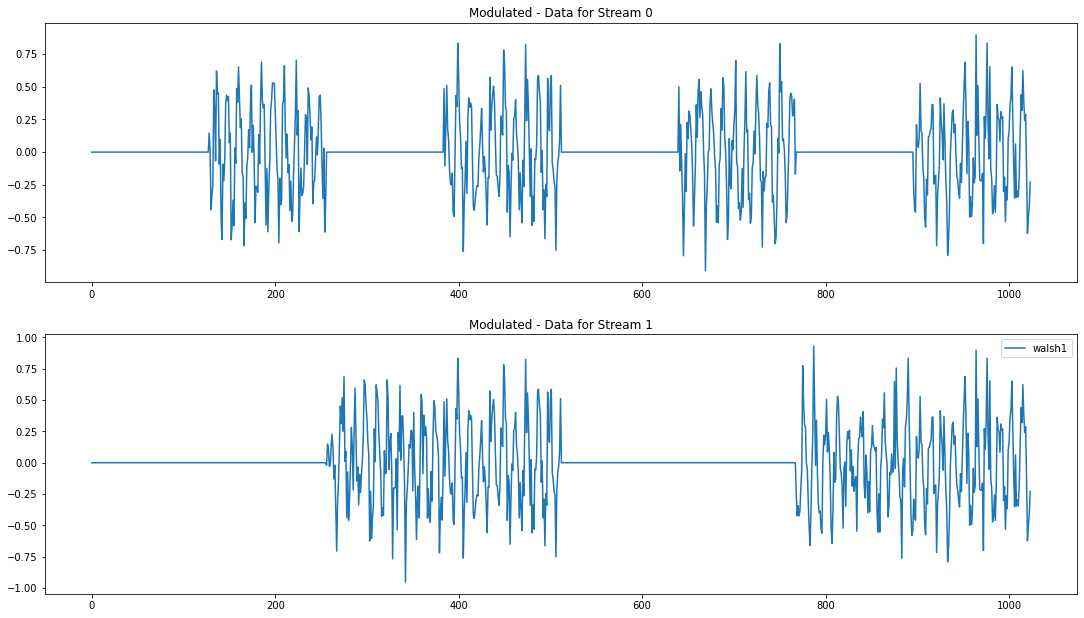

In [11]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Modulated - Data for Stream 0')
ax[1].set_title('Modulated - Data for Stream 1')
ax[0].plot(modulated0-data, label='walsh0')
ax[1].plot(modulated1-data, label='walsh1')
plt.legend()
plt.show()

# Demodulate

In [12]:
demodulated0 = np.zeros(len(walsh0extended))
demodulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        demodulated0[i] = modulated0[i]
    if walsh0extended[i] == -1:
        demodulated0[i] = -modulated0[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        demodulated1[i] = modulated1[i]
    if walsh1extended[i] == -1:
        demodulated1[i] = -modulated1[i]

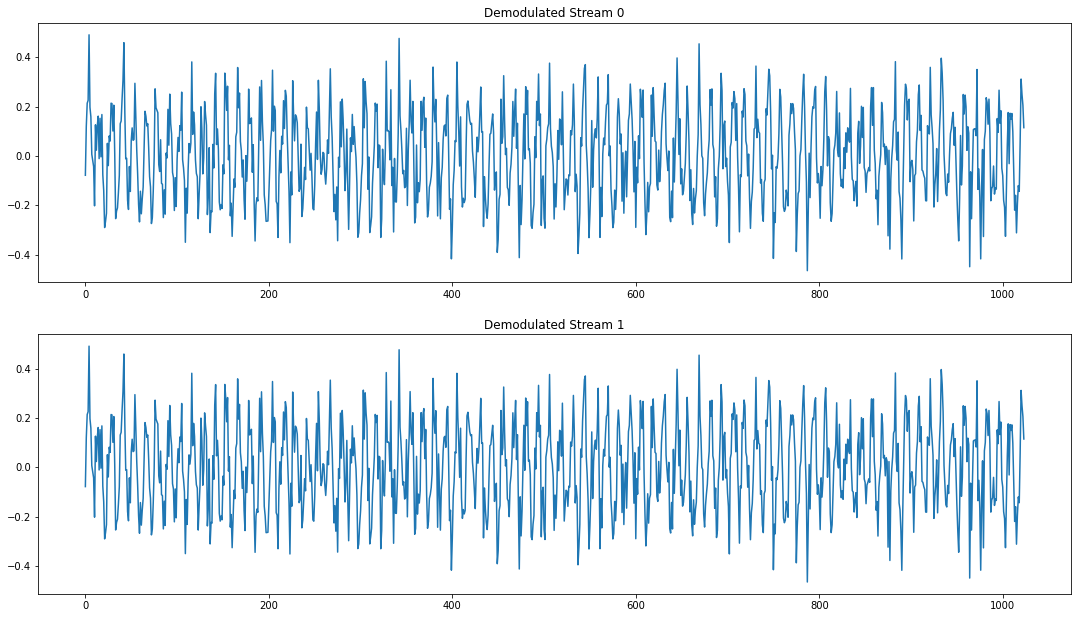

In [13]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0')
ax[1].set_title('Demodulated Stream 1')
ax[0].plot(demodulated0, label='walsh0')
ax[1].plot(demodulated1, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()

do we get the same result back?

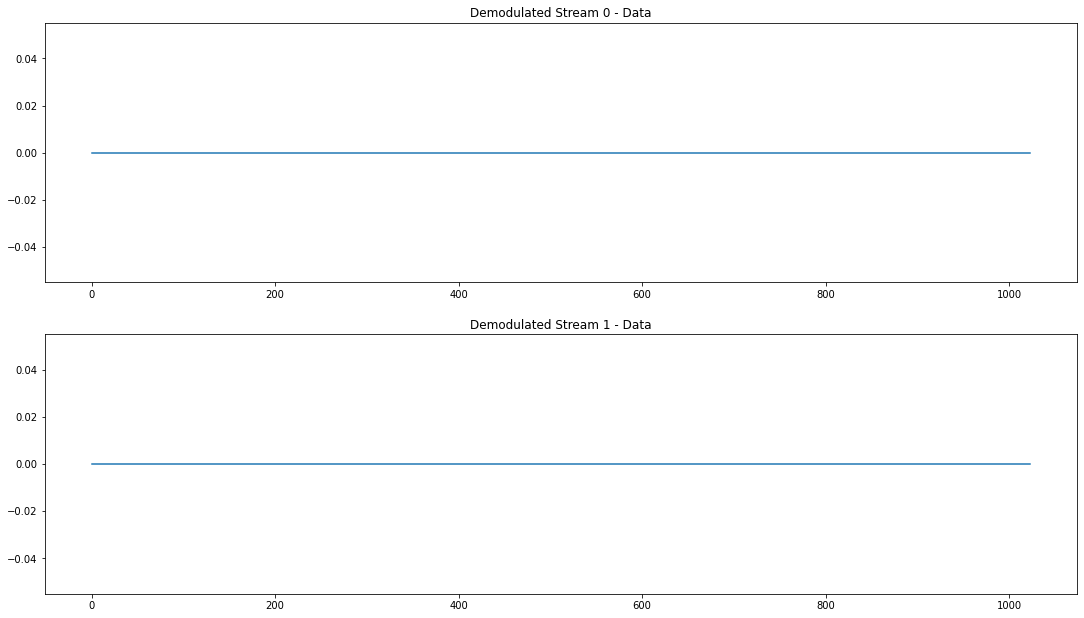

In [14]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0 - Data')
ax[1].set_title('Demodulated Stream 1 - Data')
ax[0].plot(demodulated0-data, label='walsh0')
ax[1].plot(demodulated1-data, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()

# Can we cancel out just a sine wave

In [20]:
modulated0 = cw_signal2
modulated1 = cw_signal2

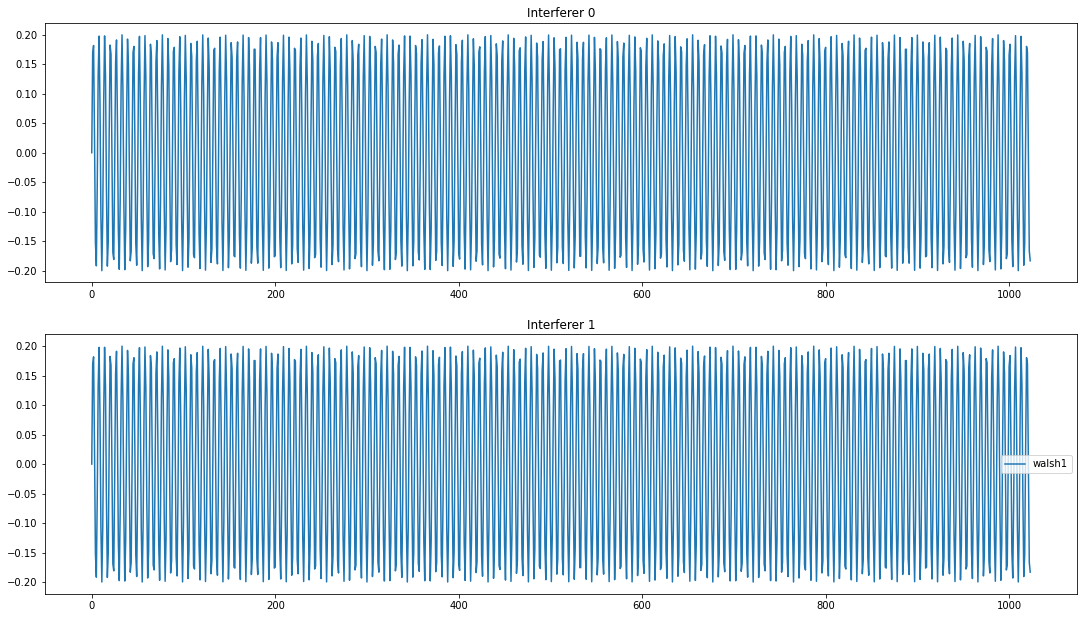

In [22]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Interferer 0')
ax[1].set_title('Interferer 1')
ax[0].plot(modulated0, label='walsh0')
ax[1].plot(modulated1, label='walsh1')
plt.legend()
plt.show()

In [23]:
demodulated0 = np.zeros(len(walsh0extended))
demodulated1 = np.zeros(len(walsh1extended))

for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        demodulated0[i] = modulated0[i]
    if walsh0extended[i] == -1:
        demodulated0[i] = -modulated0[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        demodulated1[i] = modulated1[i]
    if walsh1extended[i] == -1:
        demodulated1[i] = -modulated1[i]

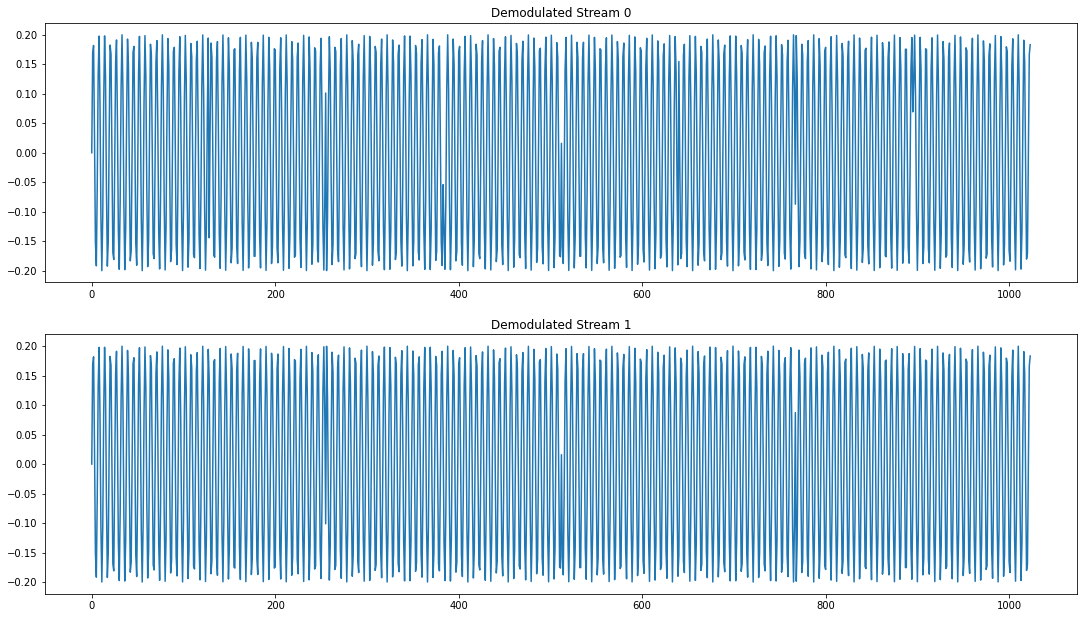

In [24]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0')
ax[1].set_title('Demodulated Stream 1')
ax[0].plot(demodulated0, label='walsh0')
ax[1].plot(demodulated1, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()


Cross correlate and sum

0.03939211679519028


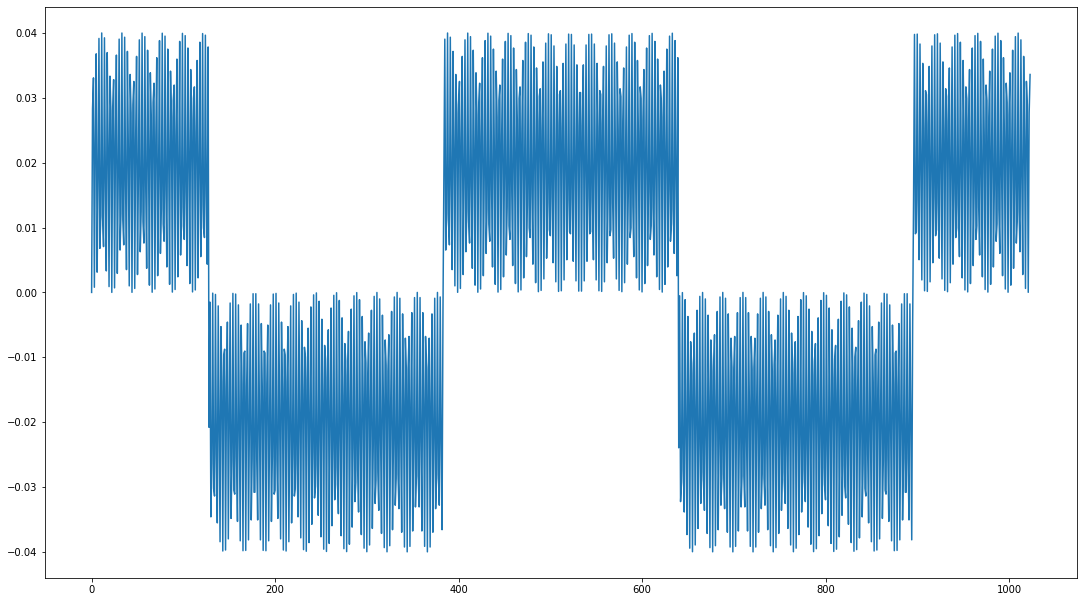

In [25]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
crossmult = demodulated0*demodulated1
plt.plot(crossmult)
summed = np.sum(crossmult)
print(summed)